In [9]:
import random
import numpy as np
import pygame
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Game Constants
WIDTH, HEIGHT = 400, 400
GRID_SIZE = 25

# Directions
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3

def get_random_position():
    x = random.randint(0, (WIDTH // GRID_SIZE) - 1) * GRID_SIZE
    y = random.randint(0, (HEIGHT // GRID_SIZE) - 1) * GRID_SIZE
    return x, y


In [ ]:
class SnakeGame:
    def __init__(self):
        self.episode = 0
        self.reset()
    
    def reset(self):
        self.snake = [(WIDTH // 2, HEIGHT // 2)]
        self.direction = random.choice([UP, DOWN, LEFT, RIGHT])
        self.food = get_random_position()
        self.score = 0
        return self.get_state()
    
    def step(self, action):
        prev_distance = self.get_distance_to_food()
        
        # Turn left or right
        if action == 0:  
            self.direction = (self.direction - 1) % 4
        elif action == 2:  
            self.direction = (self.direction + 1) % 4
        
        head_x, head_y = self.snake[0]
        if self.direction == UP:
            head_y -= GRID_SIZE
        elif self.direction == DOWN:
            head_y += GRID_SIZE
        elif self.direction == LEFT:
            head_x -= GRID_SIZE
        elif self.direction == RIGHT:
            head_x += GRID_SIZE
        
        new_head = (head_x, head_y)
        self.snake.insert(0, new_head)
        
        reward = -0.1  # Small penalty to avoid endless movement
        done = False
        
        # After moving, calculate the new distance
        new_distance = self.get_distance_to_food()

        # Calculate the distance difference
        distance_diff = prev_distance - new_distance

        # Define a scaling factor (e.g., max_distance can be based on your grid size)
        max_distance = WIDTH + HEIGHT  # Maximum possible Manhattan distance
        # Normalize the distance change
        normalized_diff = distance_diff / max_distance

        # Apply rewards based on the normalized distance change
        if distance_diff > 0:  # Getting closer to food
            reward += 0.4 + (0.2 * normalized_diff)  # Increase reward as it gets closer
        else:  # Moving away from food
            reward -= 0.2

        # Penalty when moving towards walls
        if head_x <= GRID_SIZE and self.direction == LEFT:
            reward -= 2
        elif head_x >= WIDTH - 2 * GRID_SIZE and self.direction == RIGHT:
            reward -= 2
        elif head_y <= GRID_SIZE and self.direction == UP:
            reward -= 2
        elif head_y >= HEIGHT - 2 * GRID_SIZE and self.direction == DOWN:
            reward -= 2
        
        # Reward for eating food
        if new_head == self.food:
            self.food = get_random_position()
            self.score += 1
            reward += 200
        else:
            self.snake.pop()
            reward -= 0.05  # Increment the steps without food
        
        # Collision detection
        if (head_x < 0 or head_x >= WIDTH or head_y < 0 or head_y >= HEIGHT or new_head in self.snake[1:]):
            done = True
            reward = -30
        
        return self.get_state(), reward, done
    
    def get_state(self):
        head_x, head_y = self.snake[0]
        food_x, food_y = self.food
        dx_food = (food_x - head_x) / WIDTH
        dy_food = (food_y - head_y) / HEIGHT
        return np.array([dx_food, dy_food])

    def get_distance_to_food(self):
        head_x, head_y = self.snake[0]
        food_x, food_y = self.food
        return abs(head_x - food_x) + abs(head_y - food_y)

In [11]:
# DQN Model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

In [12]:
class Agent:
    def __init__(self):
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.997
        self.learning_rate = 0.0005
        self.batch_size = 64
        self.memory = deque(maxlen=5000)
        self.model = DQN(2, 3)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 2)  
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()
    
    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        
        q_values = self.model(states).gather(1, actions)
        max_next_q_values = self.model(next_states).max(1, keepdim=True)[0].detach()
        target_q_values = rewards + (self.gamma * max_next_q_values * (1 - dones))
        
        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Training Loop
game = SnakeGame()
agent = Agent()

episodes = 1500
scores = []
total_rewards = []

for episode in range(episodes):
    state = game.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done = game.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    agent.train()
    
    scores.append(game.score)
    total_rewards.append(total_reward)
    
    print(f"Episode {episode + 1}/{episodes} | Score: {game.score} | Total Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.4f}")

torch.save(Agent().model.state_dict(), "snake_dqn.pth")

Episode 1/1500 | Score: 0 | Total Reward: -121.85 | Epsilon: 1.0000
Episode 2/1500 | Score: 0 | Total Reward: -140.03 | Epsilon: 1.0000
Episode 3/1500 | Score: 0 | Total Reward: -191.43 | Epsilon: 0.9970
Episode 4/1500 | Score: 0 | Total Reward: -296.52 | Epsilon: 0.9940
Episode 5/1500 | Score: 0 | Total Reward: -167.28 | Epsilon: 0.9910
Episode 6/1500 | Score: 1 | Total Reward: 1847.34 | Epsilon: 0.9881
Episode 7/1500 | Score: 0 | Total Reward: -160.94 | Epsilon: 0.9851
Episode 8/1500 | Score: 0 | Total Reward: -144.39 | Epsilon: 0.9821
Episode 9/1500 | Score: 0 | Total Reward: -174.21 | Epsilon: 0.9792
Episode 10/1500 | Score: 0 | Total Reward: -106.29 | Epsilon: 0.9763
Episode 11/1500 | Score: 0 | Total Reward: -232.34 | Epsilon: 0.9733
Episode 12/1500 | Score: 0 | Total Reward: -121.10 | Epsilon: 0.9704
Episode 13/1500 | Score: 0 | Total Reward: -149.61 | Epsilon: 0.9675
Episode 14/1500 | Score: 0 | Total Reward: -177.34 | Epsilon: 0.9646
Episode 15/1500 | Score: 0 | Total Reward: 

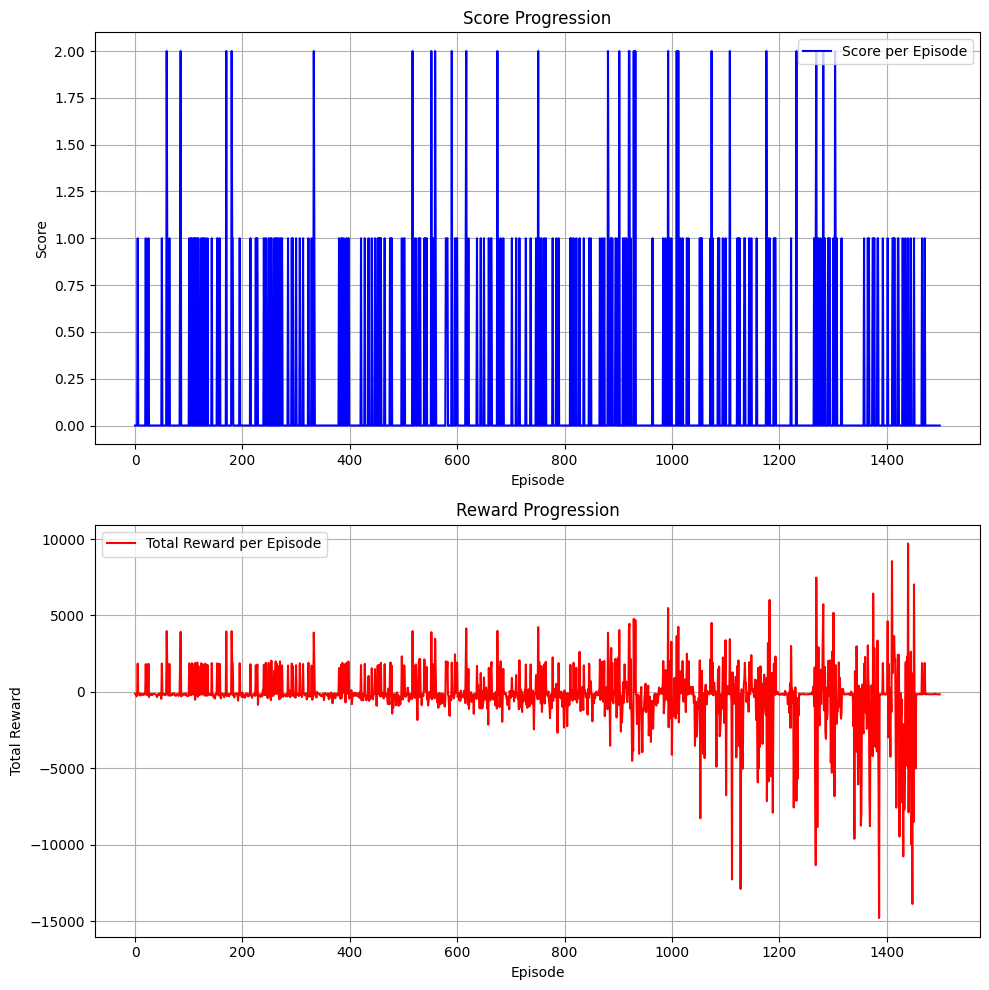

In [13]:
# Plotting Scores and Rewards
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Score Plot
axes[0].plot(scores, label="Score per Episode", color="blue")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Score")
axes[0].set_title("Score Progression")
axes[0].legend()
axes[0].grid()

# Reward Plot
axes[1].plot(total_rewards, label="Total Reward per Episode", color="red")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Total Reward")
axes[1].set_title("Reward Progression")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()